# Descriptions overlapping

For each query in the dataset, compute how many videos have overlapping tokens in their descriptions.  <br>
- No stop words (the, a, in, on, or, etc)
- Use space model for tokenization
- Compute average over all queryies

In [1]:
import spacy
import json
import sys
import numpy as np
from tqdm import tqdm

In [2]:
# Setup spacy
sp = spacy.load('en_core_web_sm')
all_stopwords = list(sp.Defaults.stop_words)
all_stopwords.extend(['.',',','"', 'A', 'The'])
tokenizer = sp.Defaults.create_tokenizer(sp)

In [15]:
# Process annotations
annotations,videos = [],[]
for split in ['train','test','val']:
    path = f'../data/processed/didemo/{split}-01.json'
    annotations.extend(json.load(open(path,'r'))['moments'])
    videos.extend(json.load(open(path,'r'))['videos'])

video_tokens = {v:[] for v in videos}
    
all_tokens = []
for i,a in enumerate(annotations):
    text_tokens = [w.text.lower() for w in tokenizer(a['description'])]       # Rokenize
    text_tokens = [t for t in text_tokens if t not in all_stopwords]  # Remove stop words
    all_tokens.extend(text_tokens)
    annotations[i]['tokens'] = text_tokens
    video_tokens[a['video']].extend(text_tokens)
    
all_tokens = list(set(all_tokens))
video_tokens = {v:list(set(t)) for v,t in video_tokens.items()}

In [16]:
# Check with how many videos each annotation has overlapping. 
d_overlapping = np.zeros(len(annotations))
num_overlaping= np.zeros(len(annotations))
for i,a in tqdm(enumerate(annotations)):
    d_t = a['tokens']
    for _,v_t in video_tokens.items():
        if any(item in d_t for item in v_t):
            d_overlapping[i] += 1
            num_overlaping[i] += len(set(d_t) & set(v_t))

41206it [16:03, 42.75it/s]


In [12]:
# Compute stats
print(f'avg number of overlapping videos {d_overlapping.mean()}')
print(f'avg number of overlapping videos {d_overlapping.mean()/len(videos)*100}')
print(f'avg number of overlapping words {num_overlaping.mean()/len(videos)}')

avg number of overlapping videos 2542.356016114158
avg number of overlapping videos 23.889832889627495
avg number of overlapping words 0.28377723513533604


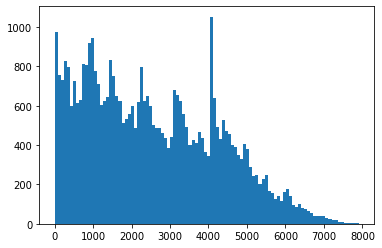

In [10]:
import matplotlib.pyplot as plt
plt.hist(d_overlapping,bins=100)
plt.show()

# Check duplicates

In [6]:
def _compute_description_tokens(annotations, video_tokens):
    for i,a in enumerate(annotations):
        text_tokens = [w.text.lower() for w in tokenizer(a['description'])]       # Rokenize
        text_tokens = [t for t in text_tokens if t not in all_stopwords]          # Remove stop words
        annotations[i]['tokens'] = text_tokens
        video_tokens[a['video']].extend(text_tokens)
    return annotations, video_tokens

In [10]:
def _compute_overlapping(ann , vid):
    overlap = np.zeros(len(ann))
    for i,a in tqdm(enumerate(ann)):
        d_t = a['tokens']
        for _,v_t in vid.items():
            if any(item in d_t for item in v_t):
                overlap[i] += 1
    return overlap

In [8]:
# 
ann_train = json.load(open('../data/processed/didemo/train-01.json','r'))['moments']
ann_val   = json.load(open('../data/processed/didemo/val-01.json'  ,'r'))['moments']
ann_test  = json.load(open('../data/processed/didemo/test-01.json' ,'r'))['moments']

vid_train = {k:[] for k in set([a['video'] for a in ann_train])}
vid_val   = {k:[] for k in set([a['video'] for a in ann_val  ])}
vid_test  = {k:[] for k in set([a['video'] for a in ann_test ])}

ann_train, vid_train = _compute_description_tokens(ann_train, vid_train)
ann_val  , vid_val   = _compute_description_tokens(ann_val  , vid_val)
ann_test , vid_test  = _compute_description_tokens(ann_test , vid_test)

In [11]:
# Compute overlapping of val set and test set with training set
over_val  = _compute_overlapping(ann_val , vid_train)
over_test = _compute_overlapping(ann_test, vid_train)

4180it [01:10, 59.38it/s]
4021it [01:08, 58.92it/s]


In [12]:
# Compute stats
print(f'avg number of overlapping videos in training with validation annotations: {over_val.mean()}')
print(f'avg number of overlapping videos in training with test annotations: {over_test.mean()}')

avg number of overlapping videos in training with validation annotations: 2041.2988038277513
avg number of overlapping videos in training with test annotations: 2050.6085550857997


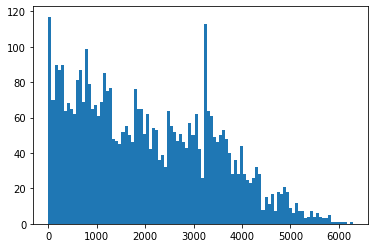

In [13]:
import matplotlib.pyplot as plt
plt.hist(over_val,bins=100)
plt.show()

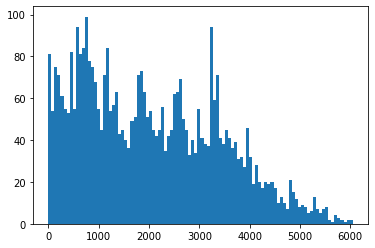

In [14]:
import matplotlib.pyplot as plt
plt.hist(over_test,bins=100)
plt.show()